In [50]:
import torch
import torchvision
import torchvision.transforms as transforms

In [51]:
root = r'E:\Work\Datasets\CIFAR10'
classes = "Plane", "Car", "Bird", "Cat", "Deer", "Dog", "Frog", "Horse", "Ship", "Truck"
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((.5, .5, .5), (.5, .5, .5))])

trainset = torchvision.datasets.CIFAR10(root=root, train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root=root, train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


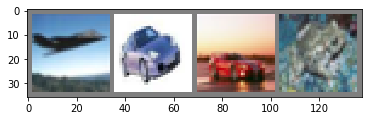

.     Plane       Car       Car       Frog


In [52]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(f".     {'       '.join(classes[labels[j]] for j in range(4))}")

In [53]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(16 * 6 * 6, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

net = Net()

In [54]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimiser = optim.SGD(net.parameters(), lr=1e-3, momentum=.9)

In [55]:
epochs = 2
for epoch in range(epochs):
    running_loss = 0
    for i, data in enumerate(trainloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimiser.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimiser.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:
            print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 2000}")
            running_loss = 0

print("Finished Training")

[1, 2000] loss: 2.2002377319931985
[1, 4000] loss: 1.9248391133844853
[1, 6000] loss: 1.6932454386875033
[1, 8000] loss: 1.5692317914515734
[1, 10000] loss: 1.4898806734755636
[1, 12000] loss: 1.4499039513319731
[2, 2000] loss: 1.3457775246798993
[2, 4000] loss: 1.3326111068576574
[2, 6000] loss: 1.2918953997977078
[2, 8000] loss: 1.2545350280590355
[2, 10000] loss: 1.2540520799476653
[2, 12000] loss: 1.2392964112721383
Finished Training


In [56]:
PATH = '../resources/cifar_net.pth'
torch.save(net.state_dict(), PATH)

In [57]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

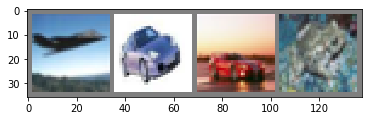

Predicted: Plane    Car    Truck    Frog


In [61]:
outputs = net(images)
_, predicted = torch.max(outputs, 1)

imshow(torchvision.utils.make_grid(images[:4]))
print(f"Predicted: {'    '.join(classes[predicted[j]] for j in range(4))}")

In [62]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f"Accuracy of the network on test images: {100 * correct / total}%")

Accuracy of the network on test images: 57.44%


In [63]:
class_correct = [0] * 10
class_total = [0] * 10
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
for i, c in enumerate(classes):
    print(f"Accuracy of {c}: {100 * class_correct[i] / class_total[i]}%")

Accuracy of Plane: 63.2%
Accuracy of Car: 61.2%
Accuracy of Bird: 46.2%
Accuracy of Cat: 35.4%
Accuracy of Deer: 44.9%
Accuracy of Dog: 31.9%
Accuracy of Frog: 78.7%
Accuracy of Horse: 69.1%
Accuracy of Ship: 63.4%
Accuracy of Truck: 80.4%


In [64]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

net.to(device)
epochs = 2

for epoch in range(epochs):
    running_loss = 0
    for i, data in enumerate(trainloader):
        inputs, labels = (d.to(device) for d in data)

        optimiser.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimiser.step()

        running_loss += loss.item()
        if i % 2000 == 1999:
            print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 2000:.3f}")
            running_loss = 0

print("Finished Training")

cuda:0
[1, 2000] loss: 1.104
[1, 4000] loss: 1.161
[1, 6000] loss: 1.130
[1, 8000] loss: 1.144
[1, 10000] loss: 1.136
[1, 12000] loss: 1.115
[2, 2000] loss: 1.137
[2, 4000] loss: 1.120
[2, 6000] loss: 1.144
[2, 8000] loss: 1.114
[2, 10000] loss: 1.153
[2, 12000] loss: 1.134
Finished Training


In [66]:
net.cpu()
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f"Accuracy of the network on test images: {100 * correct / total}%")

class_correct = [0] * 10
class_total = [0] * 10
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
for i, c in enumerate(classes):
    print(f"Accuracy of {c}: {100 * class_correct[i] / class_total[i]}%")

Accuracy of the network on test images: 57.44%
Accuracy of Plane: 63.2%
Accuracy of Car: 61.2%
Accuracy of Bird: 46.2%
Accuracy of Cat: 35.4%
Accuracy of Deer: 44.9%
Accuracy of Dog: 31.9%
Accuracy of Frog: 78.7%
Accuracy of Horse: 69.1%
Accuracy of Ship: 63.4%
Accuracy of Truck: 80.4%
